In [5]:
import seaborn as sns # for data visualization
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import json
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)


# 211223160317
# 220104230735
# 220108230116

LOGFILES =  glob.glob('../logs/cleps-logs/27012022_1107/*' )

print(LOGFILES)

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'solid',
    'SelfHealing':   'dashed',
    'Naive'      :  'dashdot',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :       'orange',
     }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

['../logs/cleps-logs/27012022_1107\\115461_0_220127140955.json', '../logs/cleps-logs/27012022_1107\\115461_0_220127144110.json', '../logs/cleps-logs/27012022_1107\\115461_0_220127152050.json', '../logs/cleps-logs/27012022_1107\\115461_0_220127154012.json', '../logs/cleps-logs/27012022_1107\\115461_0_220129060741.json', '../logs/cleps-logs/27012022_1107\\115461_0_220129061715.json', '../logs/cleps-logs/27012022_1107\\115461_0_220129062032.json', '../logs/cleps-logs/27012022_1107\\115461_0_220129062850.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127140955.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127142044.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127151253.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127154900.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127161516.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127161831.json', '../logs/cleps-logs/27012022_1107\\115462_0_220127162328.json', '../logs/cleps-logs/27012022_1107\\1154

In [6]:

#=== gather data

log = []
for logfile in LOGFILES:
    with open(logfile,'r') as f:
        for line in f:
            log += [json.loads(line)]
            
lastRunNum = None
runNums    = 0
for run in log:
    if run['runNums']!= lastRunNum:
        runNums      += 1
        lastRunNum    = run['runNums']
            
print('runNums: {} TotalRuns: {}'.format(runNums,len(log)))

runNums: 1 TotalRuns: 3838


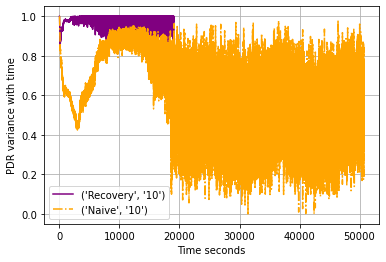

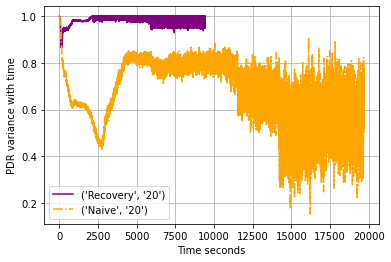

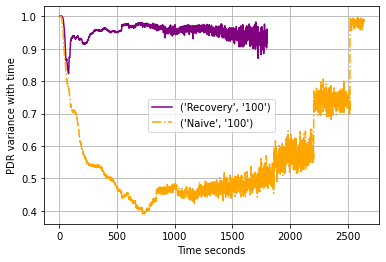

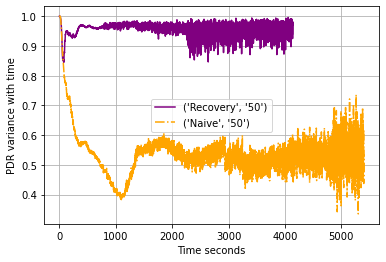

In [7]:
'''
###############################################################################
PDR Profile with Relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
swarmSizes         = []



for run in log:

    relayAlg       = run['relayAlg'] 
    navAlg         = run['navAlgorithm'] 
    
    numDotBots     = run['numDotBots']
    scenarioName   = str(numDotBots)
    scenarioNames += [scenarioName] 
       
    pdr            = run['pdrProfile']

    swarmSizes    += [numDotBots]
    pdrProfile     = run['pdrProfile']
    
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [pdrProfile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x1             = range(len(profile['mean']))
            #x             = [x*10 for x in x1]
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x1,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label= (relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    #plt.xlim(0, 300)
    plt.ylabel('PDR variance with time')

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

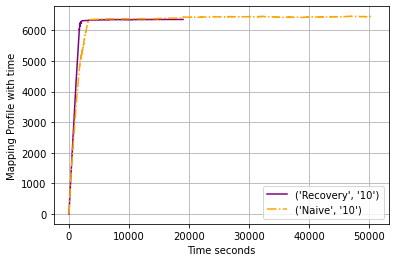

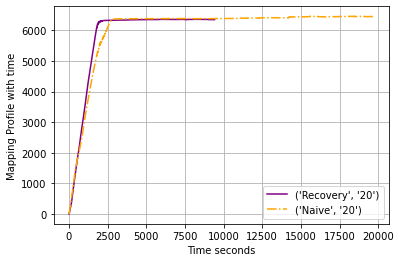

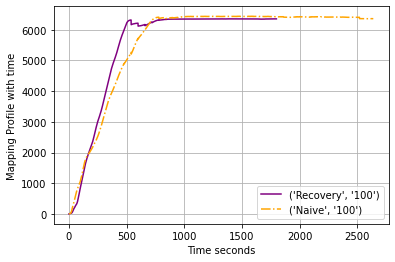

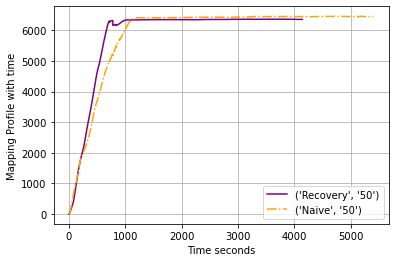

In [8]:
'''
###############################################################################
Mapping Profile with Relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
allNumRobots       = []


for run in log:

    relayAlg       = run['relayAlg'] 
    numDotBots     = run['numDotBots']
    scenarioName  = str(numDotBots)
    scenarioNames += [scenarioName] 
    
    navAlg         = run['navAlgorithm'] 
    pdr            = run['pdrProfile']
    numDotBots     = run['numDotBots']
    allNumRobots  += [numDotBots]
    mappingProfile = run['mappingProfile']
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [mappingProfile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
#         if numDotBots!=50:
#             continue
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x             = range(len(profile['mean']))
            #x             = [x*10 for x in x1]
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    #plt.xlim(0, 300)
    plt.ylabel('Mapping Profile with time')

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

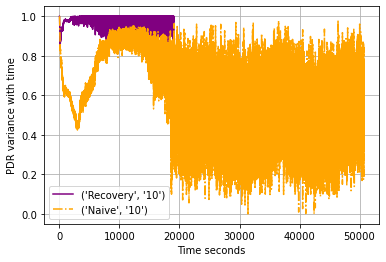

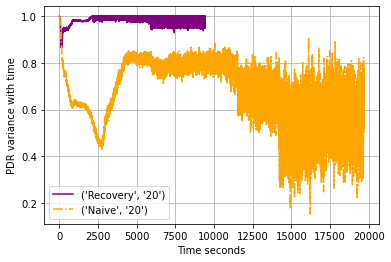

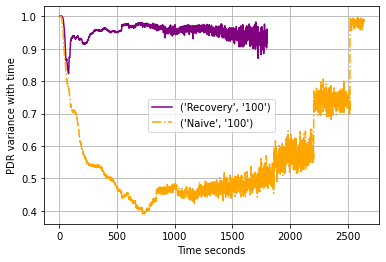

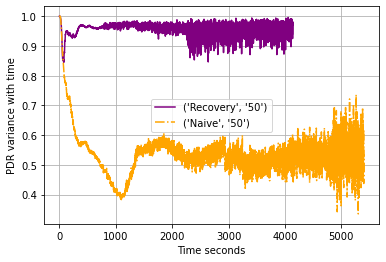

In [9]:
'''
###############################################################################
PDR vs. Time with relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
allNumRobots       = []


for run in log:

    relayAlg       = run['relayAlg'] 
    numDotBots     = run['numDotBots']
    scenarioName  = str(numDotBots)
    scenarioNames += [scenarioName] 
    
    navAlg         = run['navAlgorithm'] 
    pdrProfile     = run['pdrProfile']
    numDotBots     = run['numDotBots']
    allNumRobots  += [numDotBots]
    #mappingProfile = run['mappingProfile']
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [pdrProfile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x             = range(len(profile['mean']))
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    ax2.errorbar(x=timeline,y=relayProfile,marker= 'o',color='black',linestyle=linestyles[relayAlg],)

    ax.set_ylabel('PDR variance with time')
    ax2.set_ylabel('Number of Relays Placed')
    ax.legend(loc=8)

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

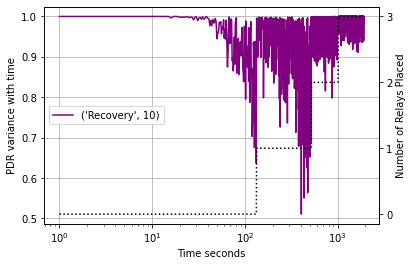

[[76.5, 19.5], [42.0, 14.0], [42.0, 21.5]]


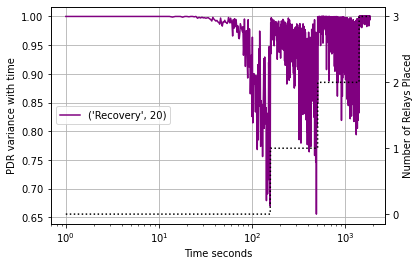

[[10.0, 8.5], [18.0, 20.0], [61.5, 14.5]]


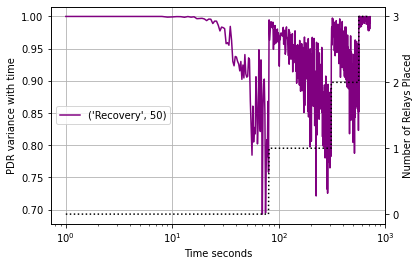

[[7.5, 11.5], [31.5, 17.5], [65.5, 2.5]]


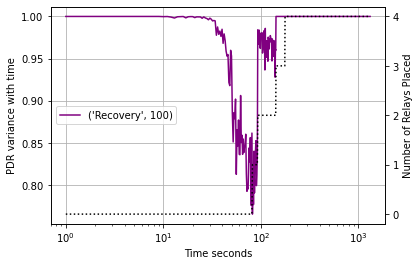

[[11.0, 12.5], [8.5, 21.0], [4.5, 21.0], [2.5, 21.5]]


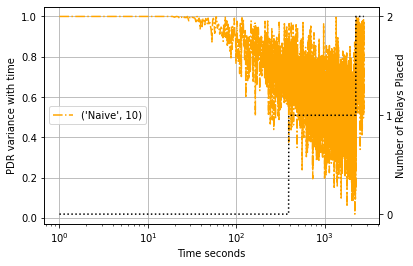

[[62.5, 3.0], [23.5, 17.0]]


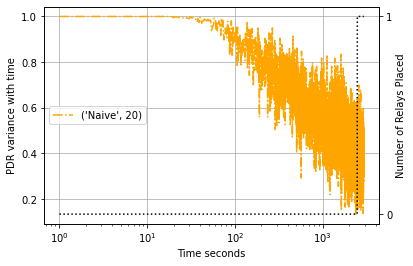

[[6.5, 13.5]]


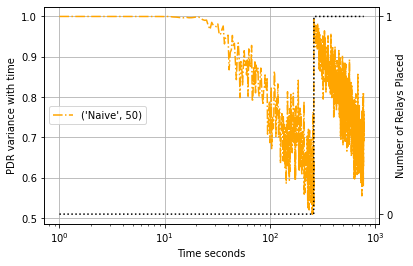

[[51.5, 15.0]]


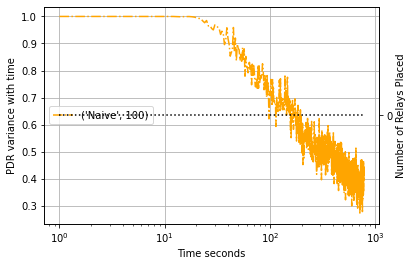

[]


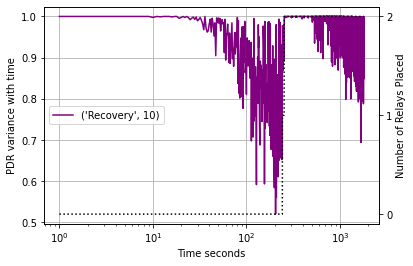

[[63.5, 8.0], [64.5, 12.0]]


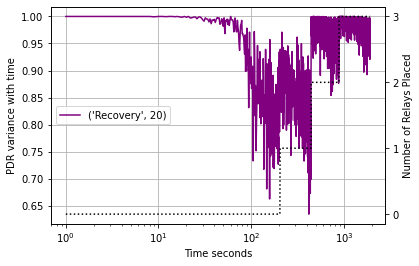

[[7.5, 14.5], [15.0, 17.5], [33.0, 12.5]]


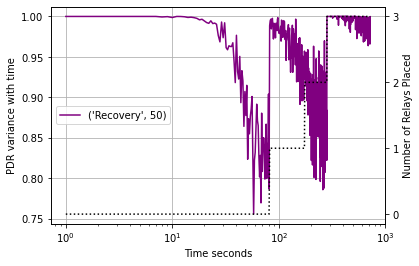

[[11.0, 11.0], [2.5, 21.0], [32.5, 14.0]]


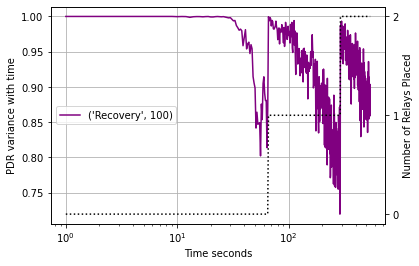

[[10.0, 7.5], [36.5, 17.5]]


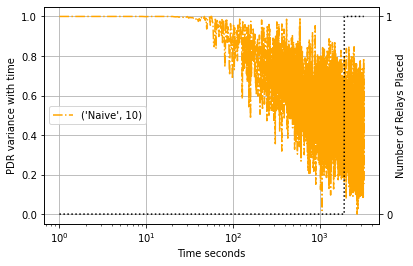

[[31.0, 1.5]]


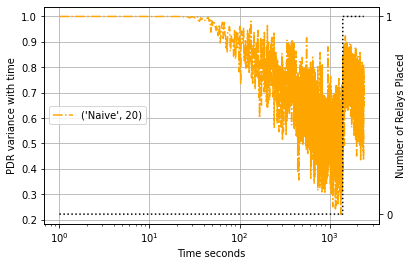

[[27.5, 7.0]]


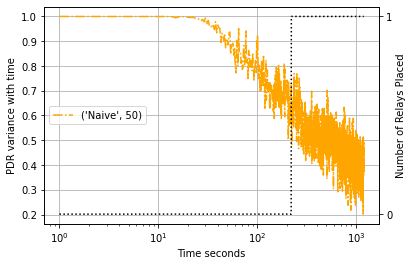

[[54.0, 10.0]]


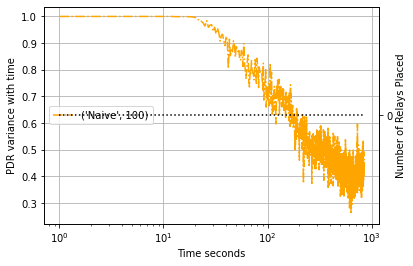

[]


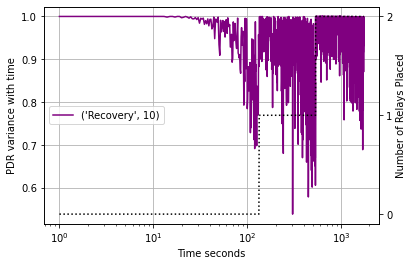

[[78.5, 19.5], [45.5, 15.0]]


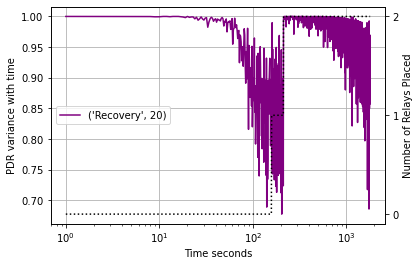

[[10.5, 7.5], [11.0, 13.5]]


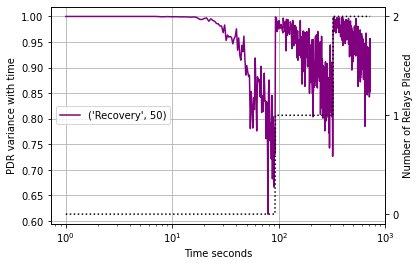

[[9.5, 12.5], [37.0, 7.5]]


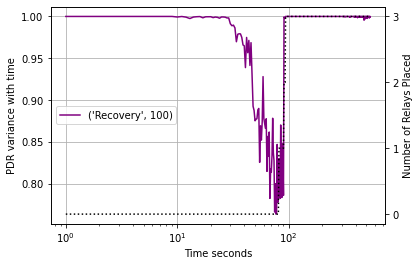

[[12.0, 12.5], [8.0, 4.5], [13.5, 8.0]]


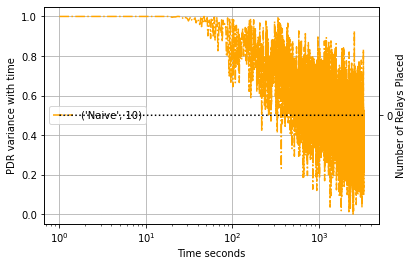

[]


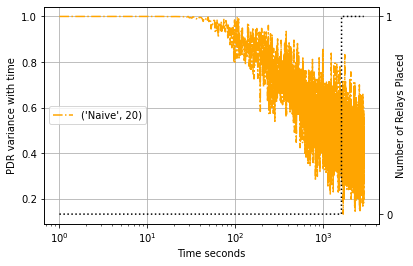

[[57.5, 17.5]]


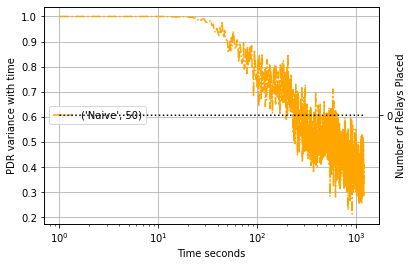

[]


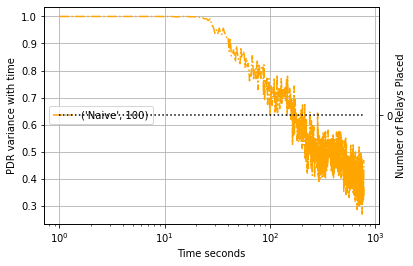

[]


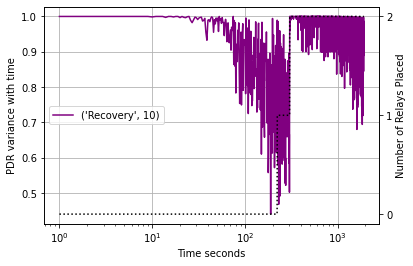

[[64.0, 11.5], [71.0, 17.5]]


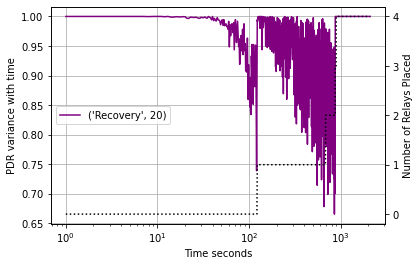

[[10.0, 3.0], [25.5, 13.0], [39.0, 12.5], [28.0, 7.5]]


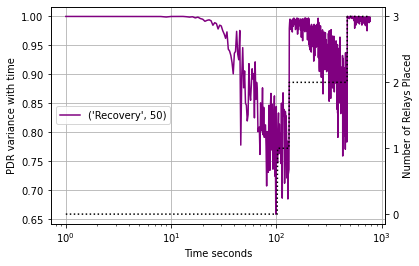

[[10.5, 14.5], [8.5, 18.5], [51.5, 1.5]]


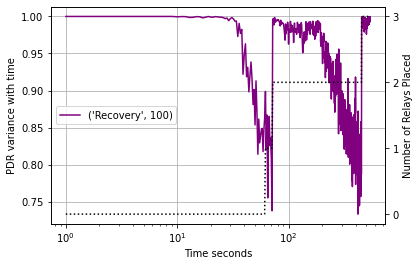

[[16.5, 15.5], [16.0, 12.5], [69.0, 20.0]]


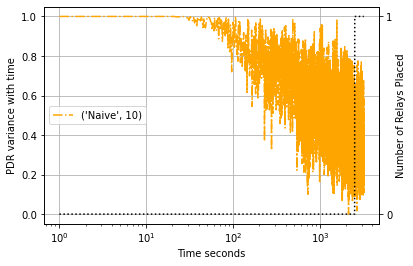

[[10.5, 3.0]]


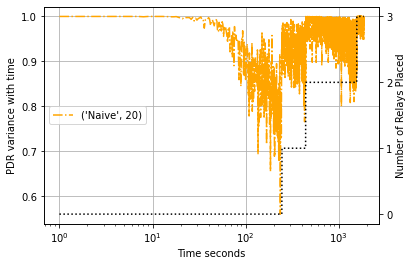

[[73.5, 2.5], [68.5, 21.0], [7.0, 4.0]]


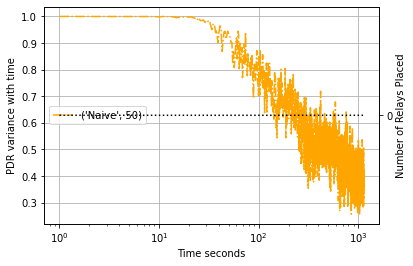

[]


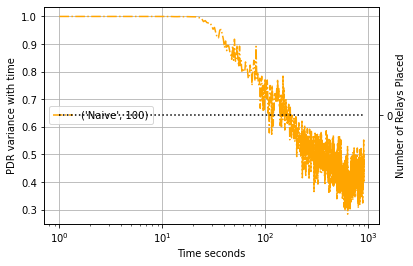

[]


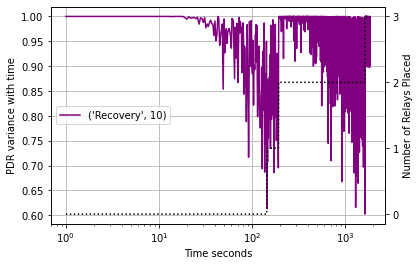

[[78.0, 2.0], [69.5, 14.0], [5.5, 21.0]]


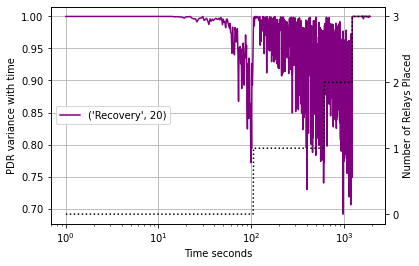

[[9.5, 4.5], [26.0, 3.0], [57.5, 13.0]]


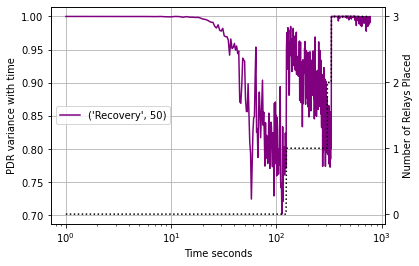

[[13.5, 6.0], [31.5, 15.5], [34.0, 4.0]]


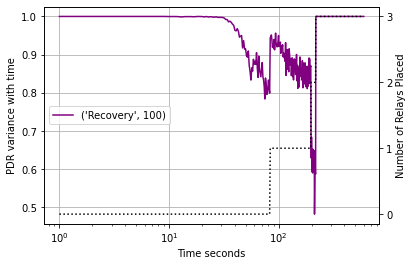

[[12.0, 9.0], [27.0, 5.0], [26.0, 15.5]]


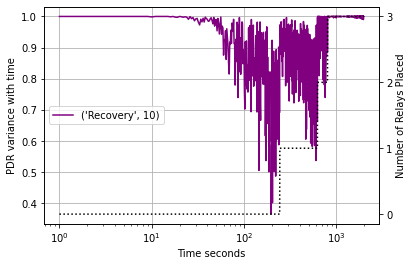

[[65.5, 14.5], [43.0, 8.5], [54.0, 21.0]]


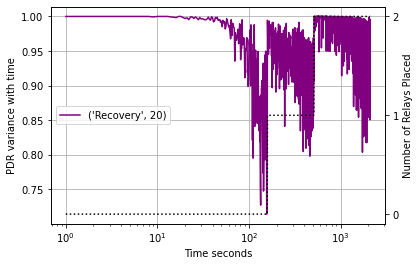

[[10.5, 5.0], [14.0, 16.5]]


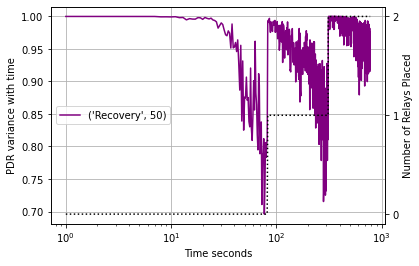

[[9.5, 12.0], [35.5, 12.5]]


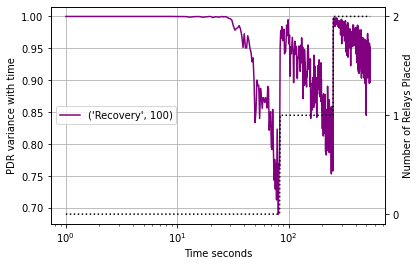

[[9.5, 6.0], [35.5, 21.5]]


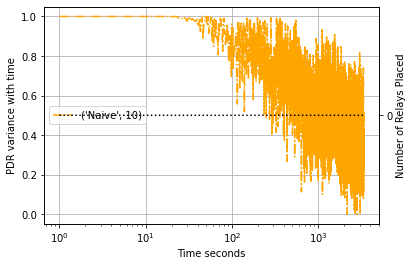

[]


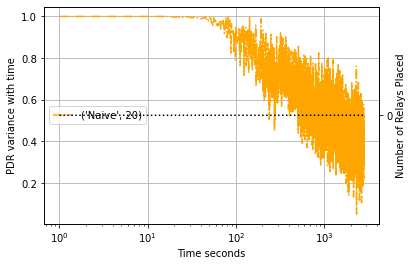

[]


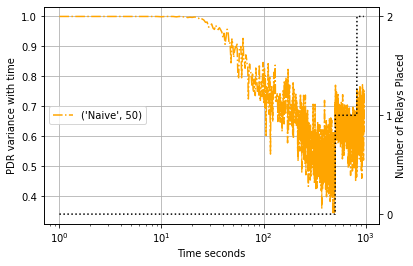

[[56.0, 21.5], [9.0, 20.5]]


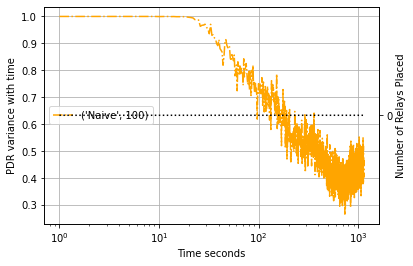

[]


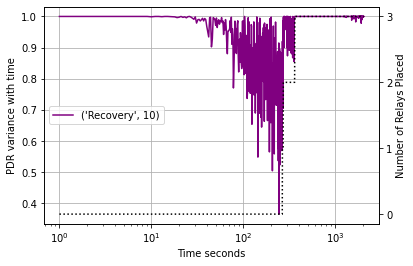

[[76.0, 15.5], [64.0, 13.0], [68.5, 1.5]]


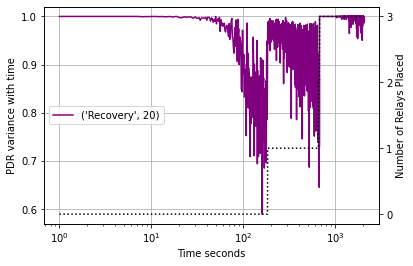

[[11.0, 11.5], [27.0, 14.0], [27.5, 16.0]]


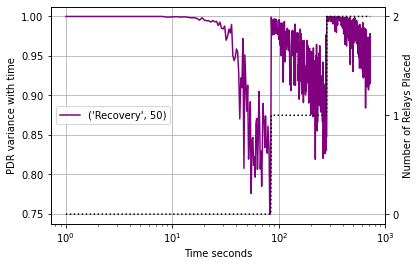

[[11.5, 8.5], [32.5, 8.0]]


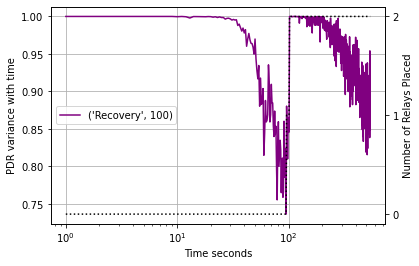

[[11.0, 11.0], [10.5, 15.0]]


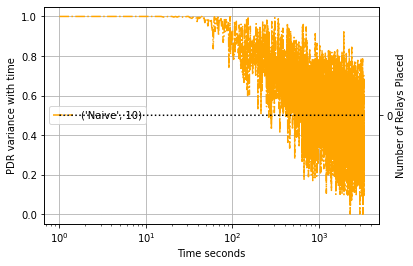

[]


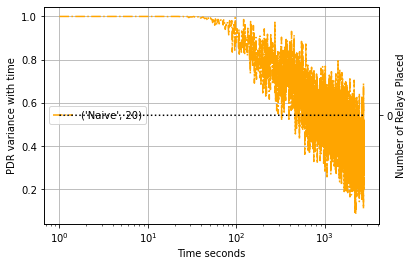

[]


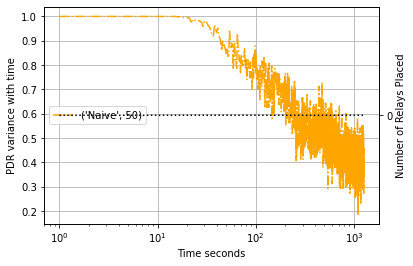

[]


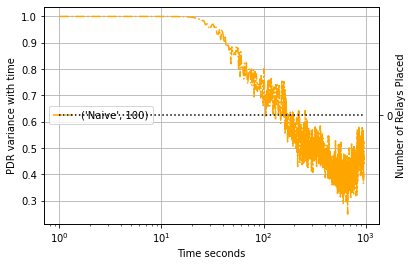

[]


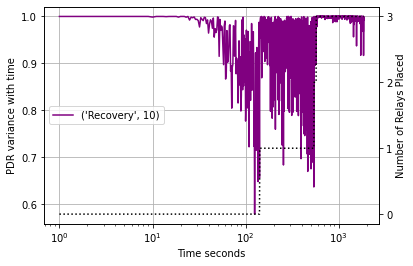

[[75.0, 20.0], [43.0, 12.5], [49.5, 14.0]]


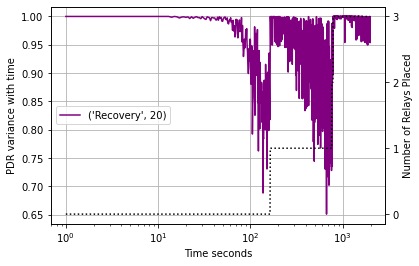

[[8.5, 10.0], [28.5, 20.0], [29.5, 1.5]]


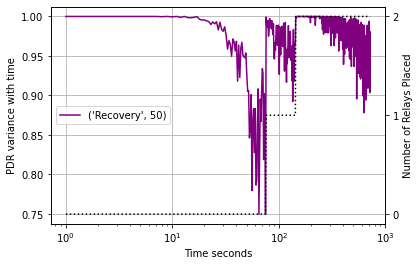

[[9.5, 6.0], [5.5, 17.0]]


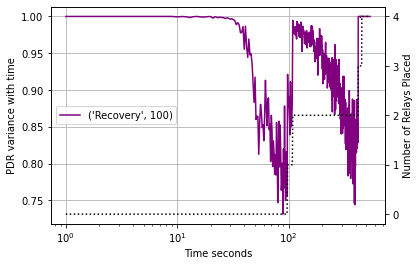

[[8.5, 6.0], [11.0, 10.0], [62.5, 18.0], [44.5, 10.0]]


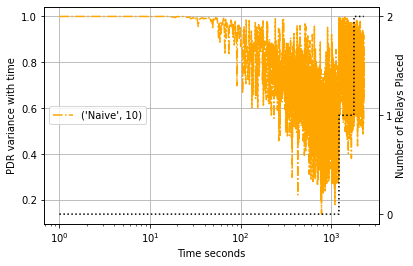

[[47.0, 3.0], [12.5, 17.5]]


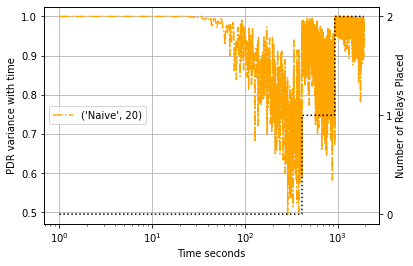

[[61.0, 5.0], [33.5, 15.5]]


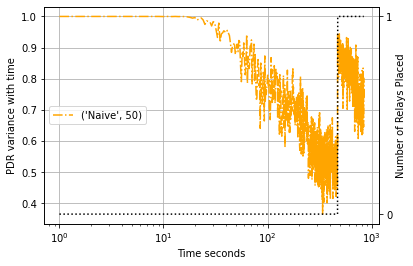

[[30.5, 15.5]]


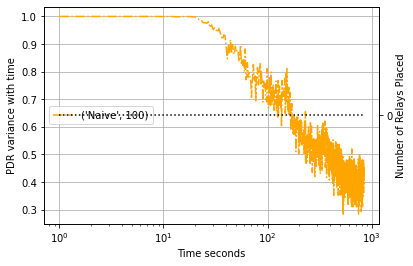

[]


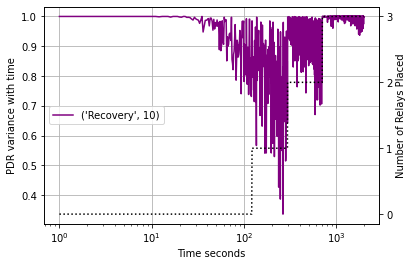

[[77.0, 2.5], [62.5, 15.5], [46.0, 5.5]]


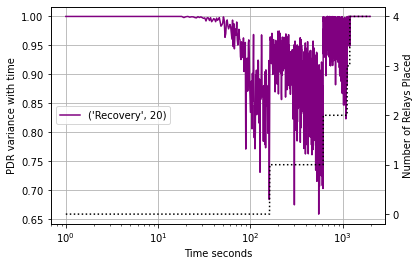

[[9.0, 11.5], [29.5, 7.5], [52.0, 9.0], [57.5, 10.5]]


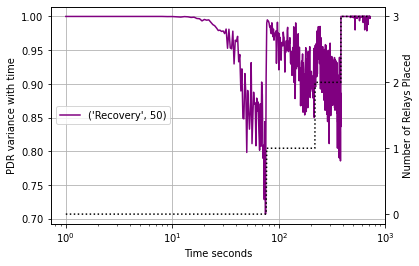

[[11.0, 7.5], [9.5, 17.5], [45.5, 9.5]]


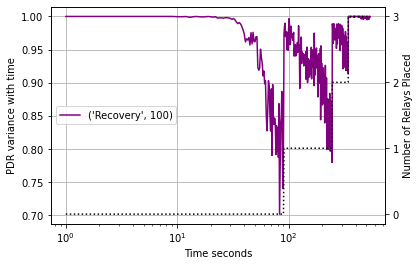

[[13.5, 6.5], [36.0, 7.5], [51.5, 2.5]]


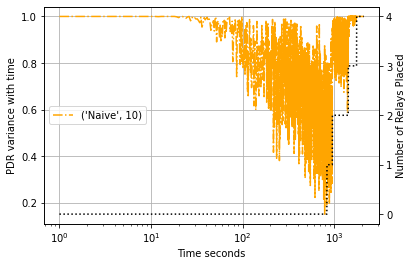

[[52.5, 5.5], [30.0, 10.0], [18.0, 8.5], [10.5, 17.5]]


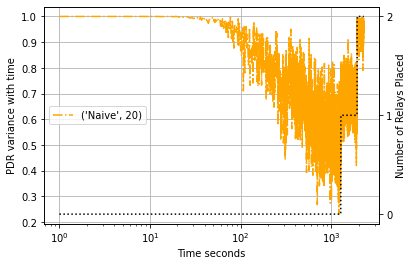

[[25.0, 10.5], [7.5, 12.5]]


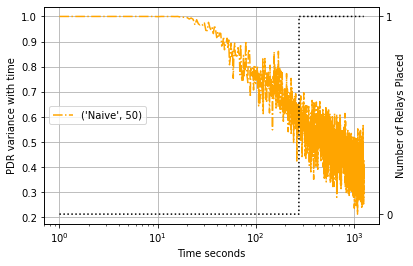

[[47.5, 12.5]]


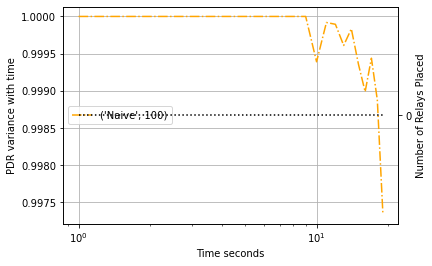

[]


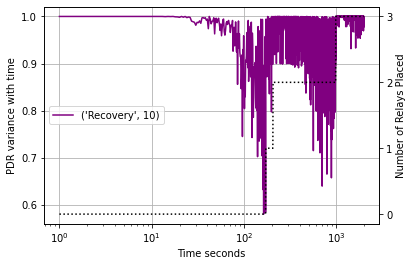

[[69.0, 11.0], [69.0, 15.5], [30.0, 14.0]]


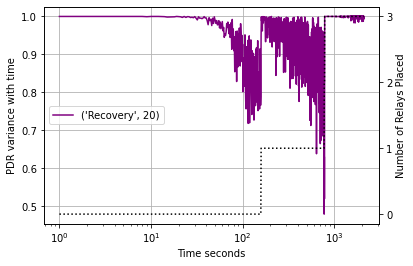

[[10.5, 8.0], [37.0, 14.0], [32.0, 8.5]]


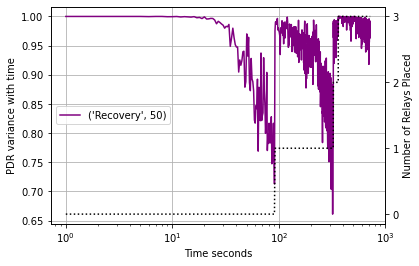

[[14.5, 15.5], [37.5, 15.5], [46.0, 13.0]]


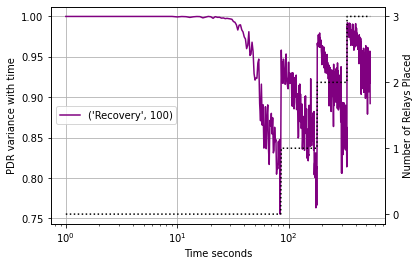

[[7.0, 9.5], [22.5, 12.5], [53.5, 13.5]]


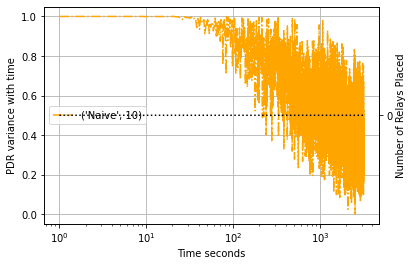

[]


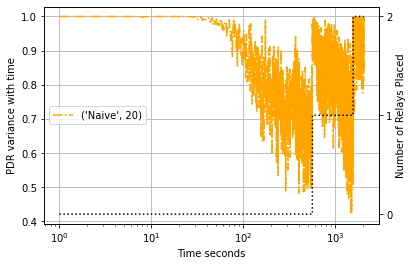

[[59.5, 14.0], [21.5, 21.5]]


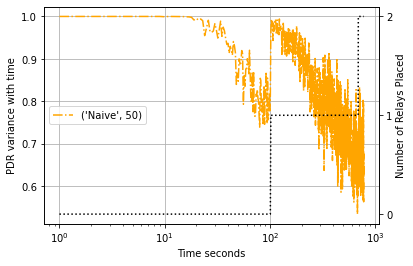

[[65.0, 15.0], [6.0, 2.0]]


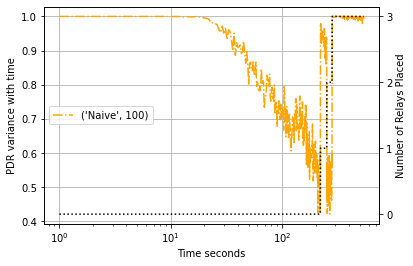

[[46.0, 14.0], [36.0, 12.5], [32.0, 8.5]]


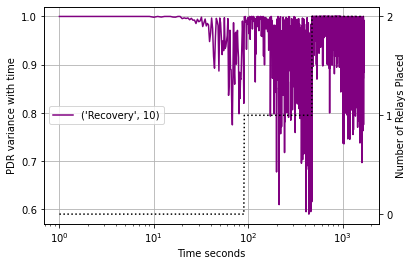

[[78.5, 18.5], [48.0, 12.5]]


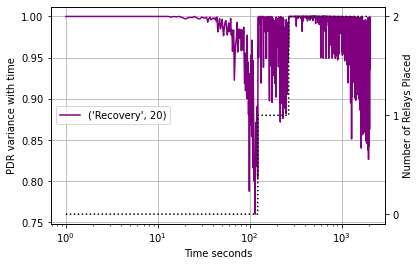

[[10.5, 5.0], [6.0, 9.5]]


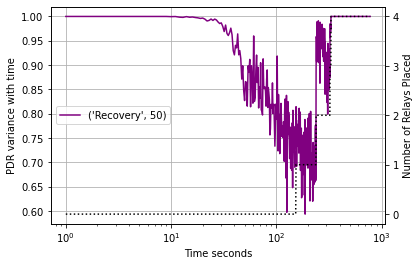

[[16.5, 13.0], [67.5, 7.5], [31.5, 15.0], [29.5, 21.5]]


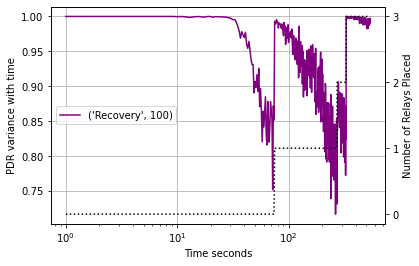

[[11.0, 9.5], [40.5, 17.0], [33.0, 17.5]]


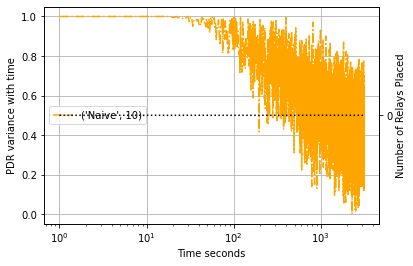

[]


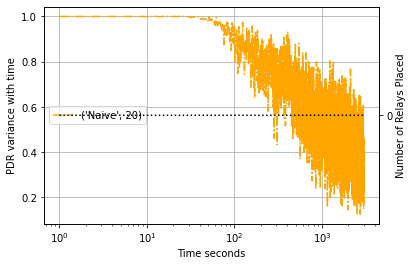

[]


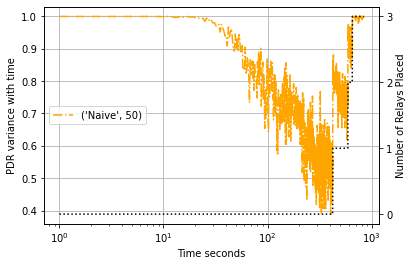

[[34.5, 10.5], [26.5, 17.0], [10.5, 9.5]]


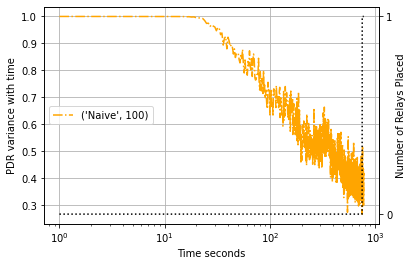

[[9.0, 21.5]]


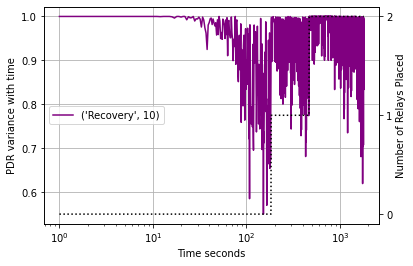

[[68.5, 10.0], [54.5, 15.5]]


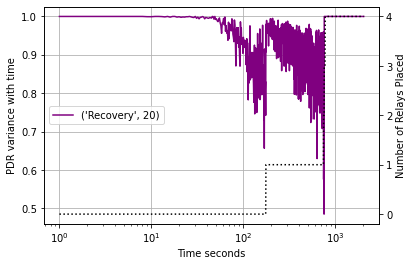

[[11.0, 8.0], [29.5, 15.5], [25.5, 19.0], [26.5, 20.5]]


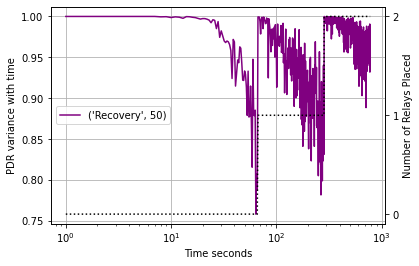

[[9.5, 7.0], [30.5, 7.5]]


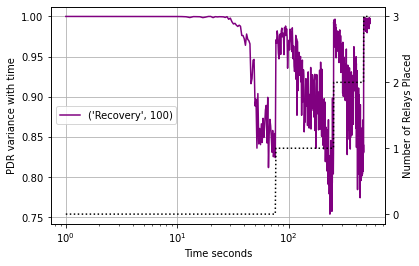

[[10.0, 5.5], [35.5, 17.5], [76.5, 8.5]]


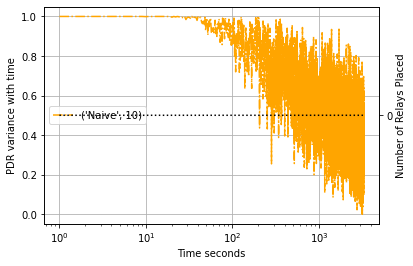

[]


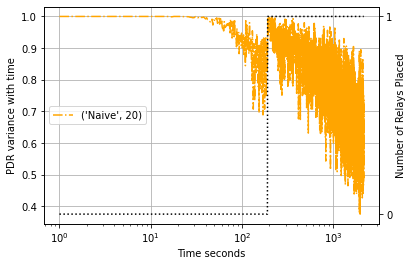

[[77.5, 21.5]]


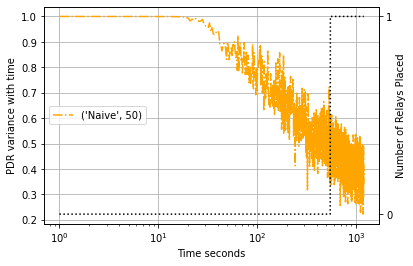

[[25.5, 8.5]]


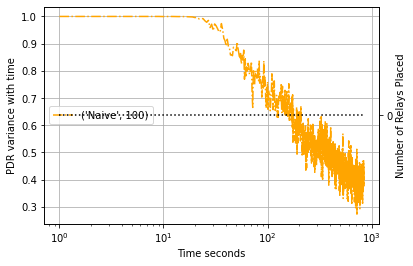

[]


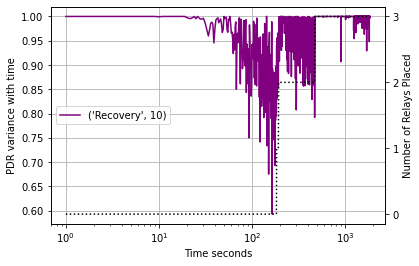

[[77.0, 1.5], [68.5, 13.5], [53.5, 14.0]]


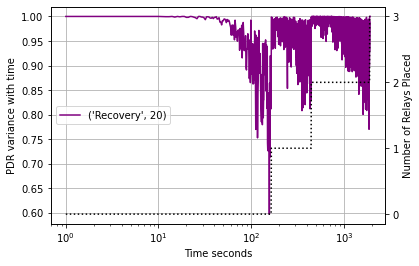

[[10.5, 8.5], [22.5, 8.0], [74.5, 16.0]]


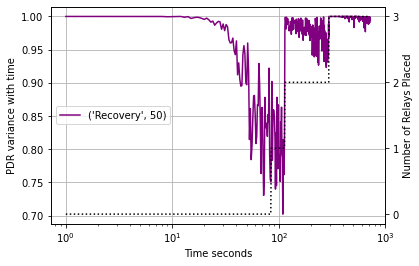

[[11.0, 8.5], [9.5, 16.0], [26.0, 1.5]]


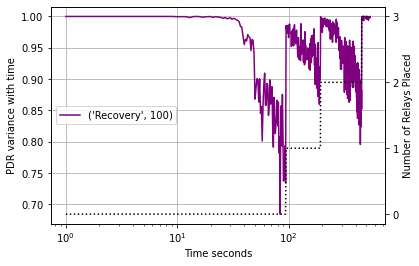

[[14.0, 16.0], [26.5, 16.0], [71.0, 20.0]]


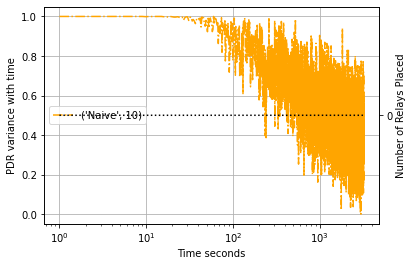

[]


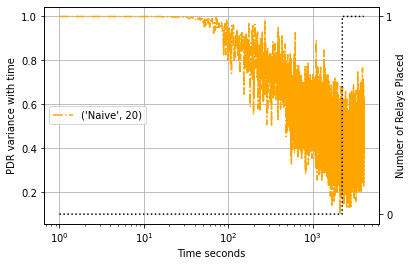

[[13.5, 16.0]]


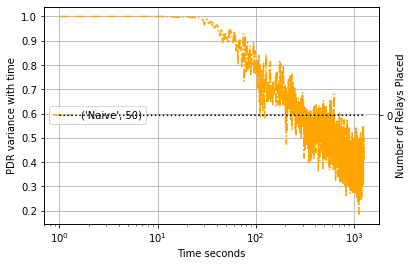

[]


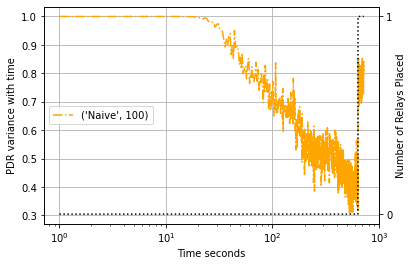

[[20.5, 19.5]]


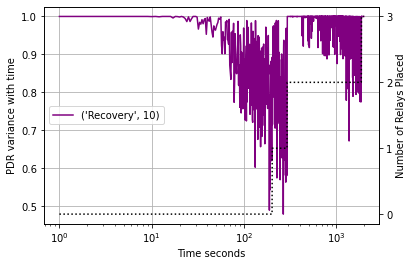

[[67.0, 13.0], [67.0, 17.5], [5.0, 14.5]]


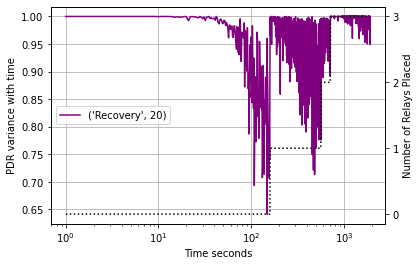

[[9.5, 7.0], [24.0, 12.5], [32.5, 14.0]]


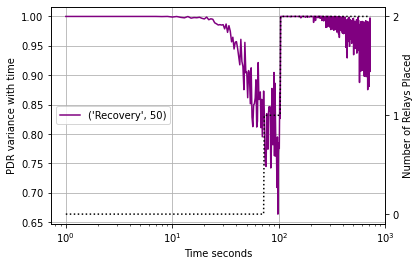

[[8.5, 9.5], [10.0, 13.5]]


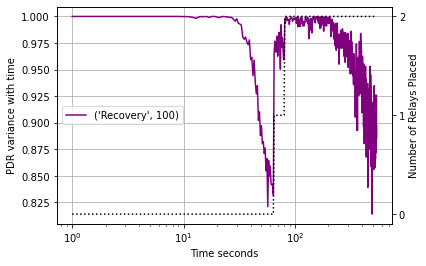

[[17.5, 14.5], [10.5, 5.0]]


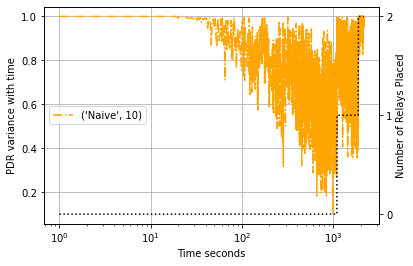

[[50.0, 21.5], [9.5, 3.5]]


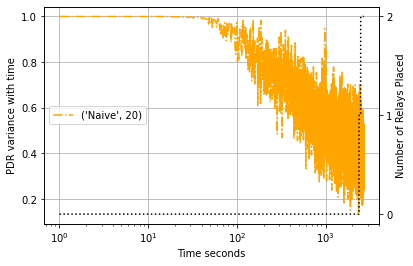

[[5.5, 1.5], [2.0, 12.5]]


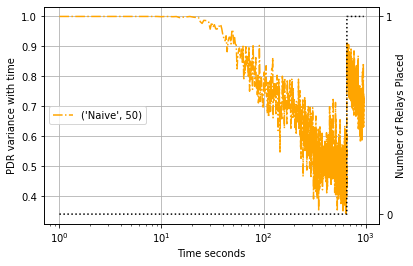

[[36.0, 1.5]]


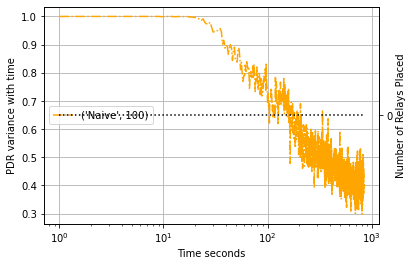

[]


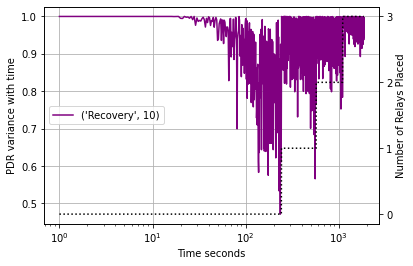

[[64.0, 14.0], [47.5, 12.5], [56.5, 3.5]]


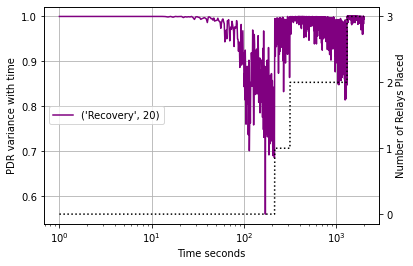

[[13.5, 8.5], [7.0, 19.0], [62.0, 7.5]]


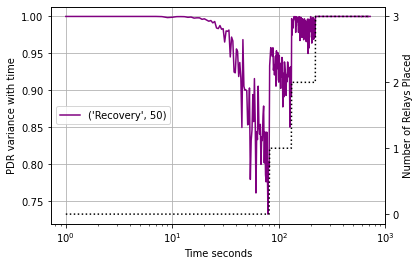

[[11.5, 8.5], [8.0, 19.5], [21.5, 21.5]]


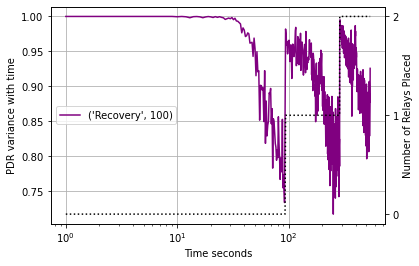

[[10.0, 21.0], [40.0, 14.0]]


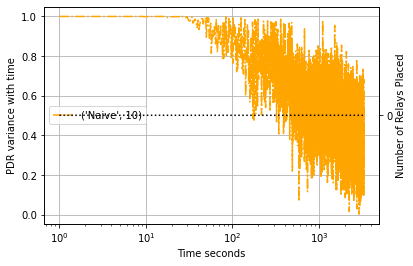

[]


In [ ]:
'''
###############################################################################
PDR vs. Time with relays
###############################################################################
'''

#=== gather data

data               = {}
scenarioNames      = []
allNumRobots       = []
pdrData            = []


for run in log:
    pdrData      = run['pdrProfile']
    swarmSize    = run['numDotBots']
    timeline     = run['timeline']
    relayAlg     = run['relayAlg']
    relayProfile = run['relayProfile']
    (fig,ax)     = plt.subplots()
    ax2 = ax.twinx()
    
    max_relays = relayProfile[-1] +1 

    ax.errorbar(x=timeline,y=pdrData,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, swarmSize))
    ax2.errorbar(x=timeline,y=relayProfile,color='black',linestyle="dotted",)
    ax.grid(True, zorder=5)
    #ax2.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1))
    ax2.yaxis.set_ticks(np.arange(0, max_relays))
    ax.set_xlabel('Time seconds')
    ax.set_ylabel('PDR variance with time')
    ax2.set_ylabel('Number of Relays Placed')
    plt.xscale('log')
    ax.legend(loc=6)
    plt.show()
    print(run['numRelays'])
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')